In [1]:
pip install --upgrade keras==2.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install --upgrade TensorFlow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.2.5'

# Understanding recurrent neural networks

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 6장 2절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

---

[...]

## 케라스의 순환 층


넘파이로 간단하게 구현한 과정이 실제 케라스의 `SimpleRNN` 층에 해당합니다:

참고: [Keras 에서의 SimpleRNN 과 LSTM](https://wikidocs.net/106473)

In [4]:
from keras.layers import SimpleRNN

`SimpleRNN`이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, `(timesteps, input_features)` 크기가 아니라 `(batch_size, timesteps, input_features)` 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)`인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)`인 2D 텐서). 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 예제를 살펴보죠:

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [7]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다:

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
17465344/17464789 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


`Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [9]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))     # Embedding 층
model.add(SimpleRNN(32))                   # SimpleRNN 층
model.add(Dense(1, activation='sigmoid'))  # 시그모이드로 결과 출력

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.6850 - acc: 0.5489 - val_loss: 0.6674 - val_acc: 0.5798
Epoch 2/10
20000/20000 [==============================] - 18s 918us/step - loss: 0.5704 - acc: 0.7187 - val_loss: 0.5553 - val_acc: 0.7116
Epoch 3/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.3655 - acc: 0.8515 - val_loss: 0.4138 - val_acc: 0.8208
Epoch 4/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.2446 - acc: 0.9023 - val_loss: 0.4013 - val_acc: 0.8374
Epoch 5/10
20000/20000 [==============================] - 18s 923us/step - loss: 0.1486 - acc: 0.9493 - val_loss: 0.5704 - val_acc: 0.7452
Epoch 6/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.0880 - acc: 0.9727 - val_loss: 0.6042 - val_acc: 0.7612
Epoch 7/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.0463 - acc: 0.9867 - val_loss: 0.5377 - va

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다:

In [10]:
import matplotlib.pyplot as plt

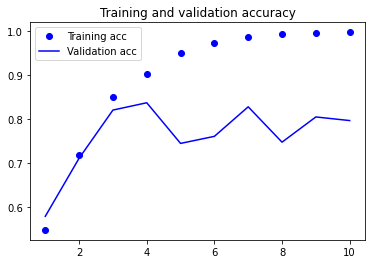

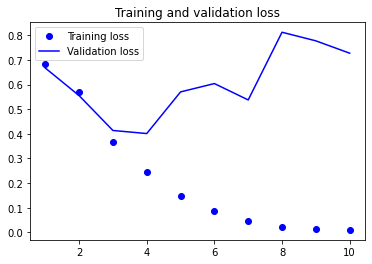

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝지만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 `SimpleRNN`이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴보죠.

[...]

## 케라스를 사용한 LSTM 예제

이제 실제적인 관심사로 이동해 보죠. LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다(그림 6-16과 6-17 참조). 이 네트워크는 조금 전 `SimpleRNN`을 사용했던 모델과 비슷합니다. LSTM 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [12]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))    # Embedding 층           
model.add(LSTM(32))                       # LSTM 층
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.5118 - acc: 0.7488 - val_loss: 0.3512 - val_acc: 0.8568
Epoch 2/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.2934 - acc: 0.8849 - val_loss: 0.3064 - val_acc: 0.8824
Epoch 3/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.2363 - acc: 0.9113 - val_loss: 0.3120 - val_acc: 0.8690
Epoch 4/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2010 - acc: 0.9245 - val_loss: 0.2817 - val_acc: 0.8894
Epoch 5/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.1810 - acc: 0.9347 - val_loss: 0.2854 - val_acc: 0.8886
Epoch 6/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.1600 - acc: 0.9430 - val_loss: 0.3321 - val_acc: 0.8598
Epoch 7/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.1442 - acc: 0.9495 - val_loss: 0.3284 - val_acc:

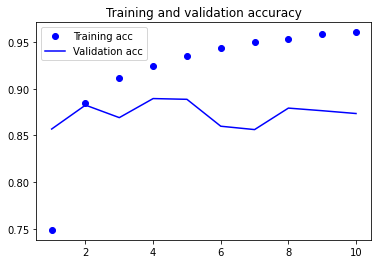

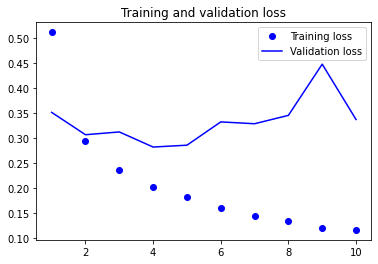

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

손실이 SimpleRNN 방식보다 줄었음.